# 2D 实验的notebook

1. 加载数据集
2. 定义模型
3. 开始训练
4. 评估

还要对比explicit和implicit，先搭一个implicit的框架，后面再慢慢优化。

## 加载数据集
- 数据集和验证集配置
- 分割数据集和验证集

In [91]:
import torch
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
ibc_parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(ibc_parent_dir)

from tqdm.auto import tqdm
from ibc import dataset, models, optimizers, trainer, utils
from scipy.spatial import ConvexHull
from ibc.trainer import PolicyType

In [92]:
train_dataset_config = dataset.DatasetConfig(
    dataset_size=10,
    seed=42, 
    # 其他参数默认
)
train_dataset = dataset.CoordinateRegression(train_dataset_config)  # data: coordinate regression shape:（N,2)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=1,
    pin_memory=torch.cuda.is_available(),
)

# Test split.
test_dataset_config = dataset.DatasetConfig(
    dataset_size=500,
    seed=42, 
)
test_dataset = dataset.CoordinateRegression(test_dataset_config)
test_dataset.exclude(train_dataset.coordinates)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=1,
    pin_memory=torch.cuda.is_available(),
)

Resampled 1 data points.


In [93]:
print(train_dataloader.dataset.get_target_bounds())

[[-1. -1.]
 [ 1.  1.]]


batch的类型: <class 'list'>
batch包含的元素数量: 2
batch[0].shape:torch.Size([8, 3, 96, 96])
batch[1].shape:torch.Size([8, 2])
tensor([ 0.8105, -0.3895])


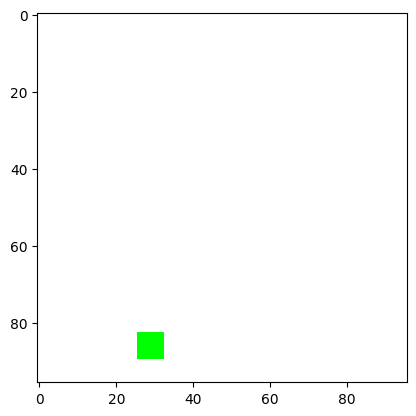

In [94]:
batch = next(iter(train_dataloader))    # 可以更改为test_dataloader查看测试集的shape

print("batch的类型:", type(batch))  # data + label
print("batch包含的元素数量:", len(batch))

for i in range(len(batch)):
    print("batch[{}].shape:{}".format(i, batch[i].shape))

# Visualize one instance.
image, target = train_dataset[np.random.randint(len(train_dataset))]
print(target)
plt.imshow(image.permute(1, 2, 0).numpy())
plt.show()

## 构造网络模型

**配置网络参数**

参数设置：

In [95]:
coord_conv = True # 是否使用坐标卷积？
in_channels = 3 # 输入通道数，对应RGB
spatial_reduction = models.SpatialReduction.SPATIAL_SOFTMAX
policy_type = PolicyType
custom_dropout_prob = 0.1
custom_learning_rate = 0.001
custom_weight_decay = 0.0001

implicit = True # 选择显式or隐式
if implicit:
    policy_type = trainer.PolicyType.IMPLICIT
else:
    policy_type = trainer.PolicyType.EXPLICIT

网络与优化器配置：

In [96]:
if coord_conv: # 如果启用坐标卷积（coord_conv），输入通道数+2（添加x/y坐标通道
    in_channels += 2
residual_blocks = [16, 32, 32]  # 残差块的数量和通道数
cnn_config = models.CNNConfig(in_channels, residual_blocks) # CNN配置
print("in channels:", in_channels)

input_dim = 16  # We have a 1x1 conv that reduces to 16 channels.
output_dim = 2
if spatial_reduction == models.SpatialReduction.SPATIAL_SOFTMAX:
    input_dim *= 2
if policy_type == trainer.PolicyType.IMPLICIT:
    input_dim += 2  # Dimension of the targets. o+a
    # print("input dimension:", input_dim)
    output_dim = 1

print("input dimension:", input_dim)

mlp_config = models.MLPConfig(
    input_dim=input_dim,
    hidden_dim=256,
    output_dim=output_dim,
    hidden_depth=1,
    dropout_prob=custom_dropout_prob,
)

model_config = models.ConvMLPConfig(
    cnn_config=cnn_config,
    mlp_config=mlp_config,
    spatial_reduction=spatial_reduction,
    coord_conv=coord_conv,
)

optim_config = optimizers.OptimizerConfig(
    learning_rate=custom_learning_rate,
    weight_decay=custom_weight_decay,
)

in channels: 5
input dimension: 34


打印配置：

In [97]:
print("mlp_config:", mlp_config)
print("model_config:", model_config)
print("optim_config:", optim_config)
net = models.ConvMLP(model_config)
print("The network structure is: \n", net)
print("The whole network has {} parameters".format(sum(p.numel() for p in net.parameters())))

mlp_config: MLPConfig(input_dim=34, hidden_dim=256, output_dim=1, hidden_depth=1, dropout_prob=0.1, activation_fn=<ActivationType.RELU: <class 'torch.nn.modules.activation.ReLU'>>)
model_config: ConvMLPConfig(cnn_config=CNNConfig(in_channels=5, blocks=[16, 32, 32], activation_fn=<ActivationType.RELU: <class 'torch.nn.modules.activation.ReLU'>>), mlp_config=MLPConfig(input_dim=34, hidden_dim=256, output_dim=1, hidden_depth=1, dropout_prob=0.1, activation_fn=<ActivationType.RELU: <class 'torch.nn.modules.activation.ReLU'>>), spatial_reduction=<SpatialReduction.SPATIAL_SOFTMAX: <class 'ibc.modules.SpatialSoftArgmax'>>, coord_conv=True)
optim_config: OptimizerConfig(learning_rate=0.001, weight_decay=0.0001, beta1=0.9, beta2=0.999, lr_scheduler_step=100, lr_scheduler_gamma=0.99)
The network structure is: 
 ConvMLP(
  (cnn): CNN(
    (net): Sequential(
      (0): Conv2d(5, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ResidualBlock(
        (conv1): Conv2d(16, 16, kernel_

创建训练进程：

In [98]:
train_state: trainer.TrainStateProtocol
if policy_type == trainer.PolicyType.EXPLICIT:
    train_state = trainer.ExplicitTrainState.initialize(
        model_config=model_config,
        optim_config=optim_config,
        device_type="cuda",
    )
else:
    target_bounds = train_dataloader.dataset.get_target_bounds()
    stochastic_optim_config = optimizers.DerivativeFreeConfig(
        bounds=target_bounds,
        train_samples=128,
    )

    train_state = trainer.ImplicitTrainState.initialize(
        model_config=model_config,
        optim_config=optim_config,
        stochastic_optim_config=stochastic_optim_config,
        device_type="cuda",
    )

Using device: cuda


## 开始训练

In [99]:
from ibc.experiment import Experiment
experiment = Experiment(
    identifier = "test_pipeline_10", # custom experiment name
).assert_new()

checkpoint_every_n_steps = 100
eval_every_n_steps = 1000
log_every_n_steps = 10

In [ ]:
for epoch in tqdm(range(2000)):
    if not train_state.steps % checkpoint_every_n_steps:
        experiment.save_checkpoint(train_state, step=train_state.steps)

    if not train_state.steps % eval_every_n_steps:
        test_log_data = train_state.evaluate(test_dataloader)
        experiment.log(test_log_data, step=train_state.steps)

    for batch in train_dataloader:
        train_log_data = train_state.training_step(*batch)

        # Log to tensorboard.
        if not train_state.steps % log_every_n_steps:
            experiment.log(train_log_data, step=train_state.steps)

# Save one final checkpoint.
experiment.save_checkpoint(train_state, step=train_state.steps)

  2%|▏         | 31/2000 [00:02<01:33, 21.17it/s]